# Imports

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import os
import utils

sns.set(style="darkgrid")
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 800)
pd.options.display.float_format = '{:.4f}'.format

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.multioutput import MultiOutputRegressor

import GPy

import xgboost as xgb


# Inspection

In [2]:
data = loadmat("data.mat")

In [3]:
data["resampledAwakeHeadAngleData"]

array([[       nan, 0.43765036, 0.62570799, ..., 2.38073996, 2.03880987,
        1.84808667]])

In [4]:
headAngel = data["resampledAwakeHeadAngleData"][0]
kaggs = data["zscoredskaggsHD"]
celldata = data["celldata"]

Check missing values

In [5]:
missing_head = np.isnan(headAngel)

In [6]:
x_dim = len(headAngel)
x_dim

15243

In [7]:
sum(missing_head)

11690

Large segments are missing

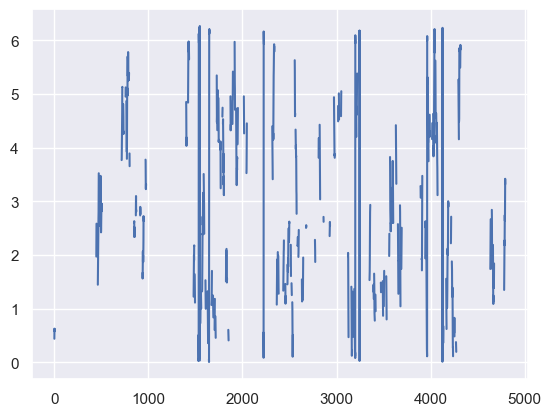

In [8]:
size = 5000
plt.plot(np.arange(size), headAngel[:size])
plt.show()

One fix is to simply remove the missing points. This is terible, since it removes the data continouity. The following plots are done with this approach

The head angel data is given in radients. This causes discontinuity at angel 0, since the radiant jumps from $2\pi$ to 0. To illustrate this, we plot the first 300 time steps of the head data. Also, the missing values causes the curve to jump a lot. 

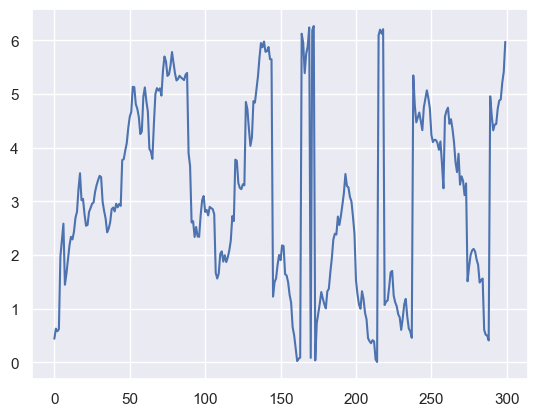

In [20]:
size = 300
headAngel_pure = headAngel[~np.isnan(headAngel)]
plt.plot(np.arange(size), headAngel_pure[:size])
plt.show()

The head angel is contious if given by sine and cosine values. 

In [21]:
sin_arr = np.sin(headAngel_pure)
cos_arr = np.cos(headAngel_pure)

Sine plot

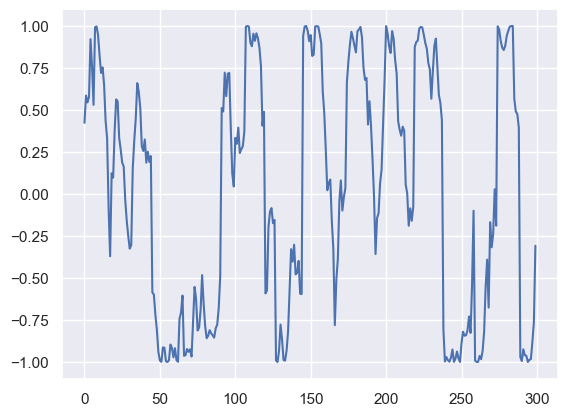

In [22]:
size = 300
plt.plot(np.arange(size), sin_arr[:size])
plt.show()

Cosine plot

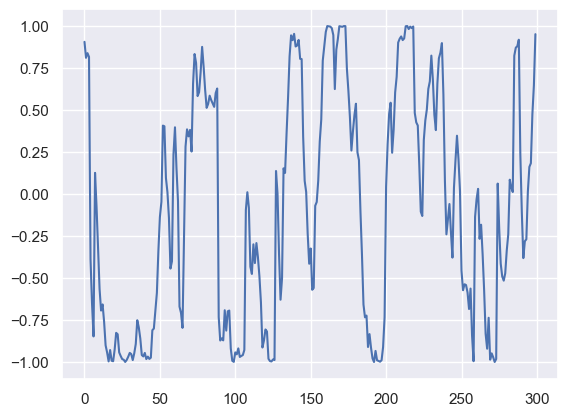

In [23]:
size = 300
plt.plot(np.arange(size), cos_arr[:size])
plt.show()

# Creat dataframe

In [9]:
df = pd.DataFrame({"headAngel":headAngel})
df["sin_angel"] = np.sin(df["headAngel"])
df["cos_angel"] = np.cos(df["headAngel"])
for i in range(celldata.shape[0]):
    name = "cell_"+f"{i}"
    df[name] = celldata[i]

df.head()

,headAngel,sin_angel,cos_angel,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,cell_9,cell_10,cell_11,cell_12,cell_13,cell_14,cell_15,cell_16,cell_17,cell_18,cell_19,cell_20,cell_21,cell_22,cell_23,cell_24,cell_25,cell_26,cell_27,cell_28,cell_29,cell_30,cell_31,cell_32,cell_33,cell_34,cell_35,cell_36,cell_37,cell_38,cell_39,cell_40,cell_41,cell_42,cell_43,cell_44,cell_45,cell_46,cell_47,cell_48,cell_49,cell_50,cell_51,cell_52,cell_53,cell_54,cell_55,cell_56,cell_57,cell_58,cell_59,cell_60,cell_61,cell_62,cell_63,cell_64,cell_65,cell_66,cell_67,cell_68,cell_69,cell_70
0,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,7.0000,10.0000,2.0000,0.0000,0.0000,0.0000,2.0000,5.0000,0.0000,1.0000,2.0000,0.0000,0.0000,0.0000,2.0000,5.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.0000,0.0000,13.0000,2.0000,12.0000,0.0000,8.0000,0.0000,0.0000,0.0000,7.0000,0.0000,0.0000,4.0000,1.0000,0.0000,3.0000,0.0000,0.0000,12.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000
1,0.4377,0.4238,0.9057,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0000,10.0000,2.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,3.0000,2.0000,0.0000,0.0000,8.0000,0.0000,0.0000,0.0000,0.0000,8.0000,3.0000,13.0000,0.0000,5.0000,0.0000,0.0000,0.0000,7.0000,1.0000,0.0000,7.0000,0.0000,0.0000,0.0000,0.0000,0.0000,11.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000
2,0.6257,0.5857,0.8105,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,4.0000,4.0000,0.0000,0.0000,0.0000,2.0000,5.0000,0.0000,3.0000,1.0000,0.0000,0.0000,0.0000,3.0000,3.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.0000,0.0000,13.0000,0.0000,10.0000,0.0000,5.0000,0.0000,0.0000,1.0000,4.0000,0.0000,0.0000,7.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,9.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.5764,0.5450,0.8384,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.0000,4.0000,4.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,3.0000,4.0000,0.0000,0.0000,6.0000,0.0000,0.0000,0.0000,0.0000,10.0000,3.0000,10.0000,0.0000,4.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,11.0000,0.0000,0.0000,1.0000,0.0000,0.0000,14.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,10.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.6162,0.5779,0.8161,2.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,9.0000,2.0000,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,4.0000,2.0000,0.0000,1.0000,9.0000,0.0000,0.0000,0.0000,1.0000,9.0000,6.0000,9.0000,0.0000,5.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [11]:
df.to_csv("df.csv", index = False)

## Split into train, test and validation set

In [13]:
df = pd.read_csv("df.csv")

In [18]:
tot_len = df.shape[0]
train_len = round(tot_len*0.5)
val_len = round(tot_len*0.8)

ind = np.arange(tot_len)
train_ind = ind[:train_len]
val_ind = ind[train_len:val_len]
test_ind = ind[val_len:]

In [19]:
df_train = df.loc[train_ind]
df_val = df.loc[val_ind]
df_test = df.loc[test_ind]

In [20]:
df_train.to_csv("df_train.csv")
df_val.to_csv("df_val.csv")
df_test.to_csv("df_val.csv")

# Fill missing data

In [22]:
df_train.isnull().sum()

headAngel    6234
cell_0          0
cell_1          0
cell_2          0
cell_3          0
cell_4          0
cell_5          0
cell_6          0
cell_7          0
cell_8          0
cell_9          0
cell_10         0
cell_11         0
cell_12         0
cell_13         0
cell_14         0
cell_15         0
cell_16         0
cell_17         0
cell_18         0
cell_19         0
cell_20         0
cell_21         0
cell_22         0
cell_23         0
cell_24         0
cell_25         0
cell_26         0
cell_27         0
cell_28         0
cell_29         0
cell_30         0
cell_31         0
cell_32         0
cell_33         0
cell_34         0
cell_35         0
cell_36         0
cell_37         0
cell_38         0
cell_39         0
cell_40         0
cell_41         0
cell_42         0
cell_43         0
cell_44         0
cell_45         0
cell_46         0
cell_47         0
cell_48         0
cell_49         0
cell_50         0
cell_51         0
cell_52         0
cell_53         0
cell_54   

## Simple methods

In [17]:
# Interpolation
df_train["interpolated_angel"] = df_train["headAngel"].interpolate(option = "spline")
# Exponential moving average
df_train["ema_angel"] = df_train["headAngel"].ewm(halflife=4).mean()

### Interpolation

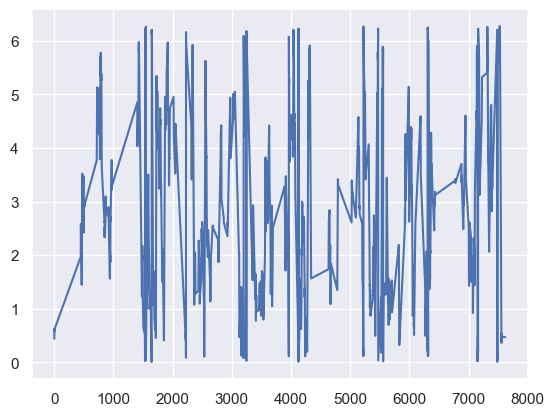

In [18]:
plt.plot(np.arange(train_len), df_train["interpolated_angel"])
plt.show()

### Exponential Moving Average

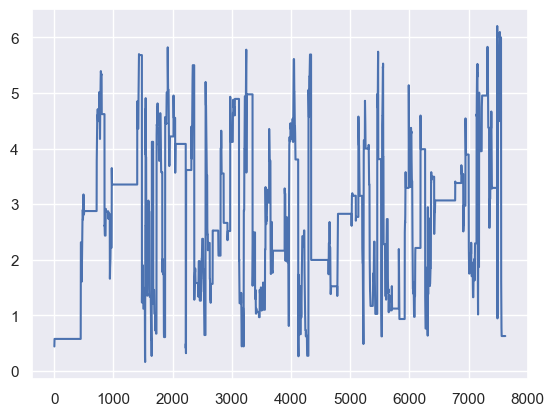

In [19]:
plt.plot(np.arange(train_len), df_train["ema_angel"])
plt.show()

## Gaussian process

In [25]:
missing_head = df_train["headAngel"].isnull()

time_full = np.arange(train_len).reshape(-1,1)
time = time_full[np.invert(missing_head),]
time_continous = np.linspace(start = time_full[0][0], stop = time_full[-1][0], num = 1000)

head_full = np.array(df_train["headAngel"])
head = head_full[np.invert(missing_head)]

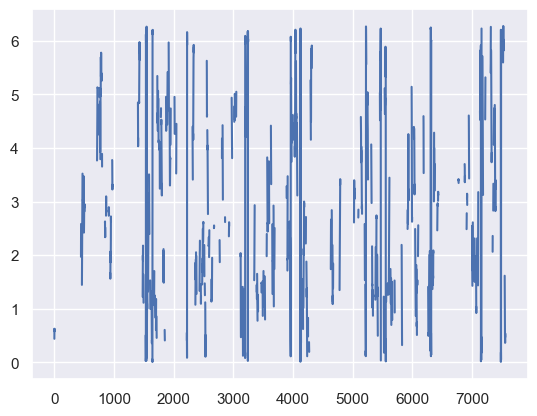

In [12]:
plt.plot(time_full, head_full)
plt.show()

In [13]:
kernel = ConstantKernel(1.0) * RBF(length_scale=1.0)

In [14]:
gpr = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=2, normalize_y=True)
gpr.fit(time, head)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=2, normalize_y=True)

In [19]:
pred = gpr.predict(time_full)

In [15]:
gpr_sample = gpr.sample_y(time_full)

In [23]:
sample_mod = np.mod(sample, 2*np.pi)

One sample

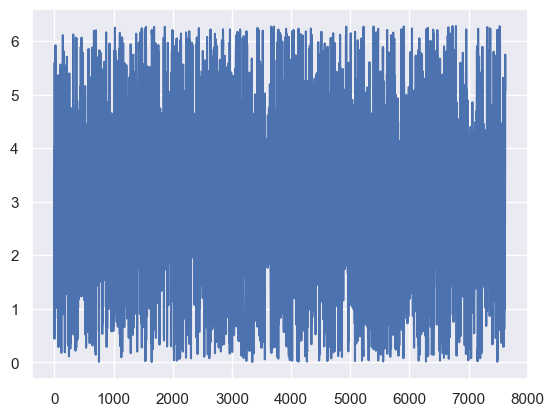

In [24]:
plt.plot(time_full, sample_mod)
plt.show()

Mean of the posterior

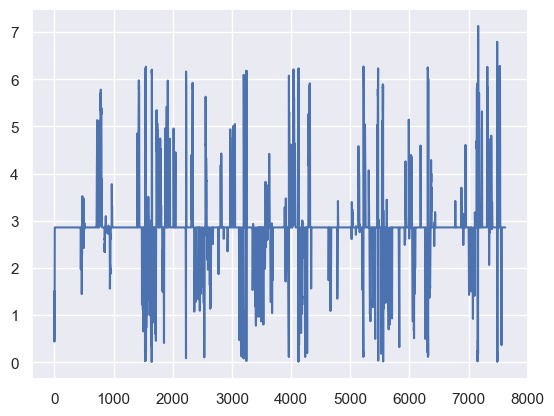

In [20]:
plt.plot(time_full, pred)
plt.show()

We see that the mean quickly regresses to the mean of the sample when there is no other data points in the proximity. This makes the time series have a unatrual shape and is therefor troublesome to use when filling missing values. I propose that one should rather sample from the posterior and build models for each posterior, then take the mean prediction of all models to be the true prediction.

I found sklearn to be slow, so I use a better library.

### GPy

In [26]:
head_vec = head.reshape(-1,1)
time_vec = np.array(time)

kernel = GPy.kern.RBF(input_dim=1, lengthscale=1., variance = 1)
model = GPy.models.GPRegression(time, head_vec, kernel, normalizer = True, noise_var = 0,)

In [27]:
GP_mean, GP_var = model.predict(time_full)
GP_mean

array([[1.49236631],
       [0.43765038],
       [0.62570799],
       ...,
       [2.85779002],
       [2.85779002],
       [2.85779002]])

In [28]:
GP_samples = model.posterior_samples_f(time_full, full_cov = True, size = 20)

In [45]:
GP_samples = GP_samples.reshape(7622,20)
GP_samples = np.transpose(GP_samples)

In [50]:
pd.DataFrame(GP_samples).to_csv("gp_samples.csv", index = False)

In [47]:
GP_sample_mod = np.mod(GP_samples[0], 2*np.pi)

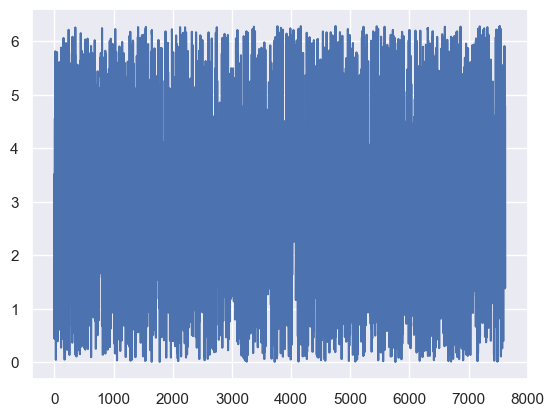

In [49]:
plt.plot(time_full, GP_sample_mod)
plt.show()

### GPflow


In [ ]:
model = gpflow.models.GPR(
    (time, head),
    kernel=gpflow.kernels.SquaredExponential(),
)

NameError: name 'gpflow' is not defined

In [ ]:
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

## MICE

## Simple

In [163]:
df_miss = np.concatenate((head_full.reshape(-1,1), time_full), axis = 1)

imp = IterativeImputer(random_state=0)
X_imp = imp.fit_transform(df_miss)

In [170]:
pred = X_imp.transpose()[0]
pred

array([2.80271557, 0.43765036, 0.62570799, ..., 2.38073996, 2.03880987,
       1.84808667])

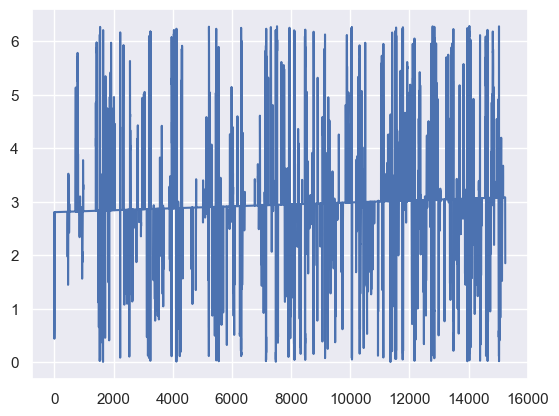

In [172]:
plt.plot(time_full, pred)
plt.show()

## Sliding window

In [173]:
win_size = 90
X = sliding_window_view(df['headAngel'].values, win_size)

X = np.concatenate((X, df.index.values[:len(X)].reshape(-1,1)), axis=1)

imp = IterativeImputer(random_state=0)
X_imp = imp.fit_transform(X)

(15154, 90)


In [190]:
matrix = X_imp[:,range(win_size)]
diags = [matrix[::-1,:].diagonal(i) for i in range(-matrix.shape[0]+1,matrix.shape[1])]

train = pd.DataFrame({"y" : df['headAngel'].values})

train['y_mean'] = np.nan
train['y_std'] = np.nan

for i,v in enumerate(diags):
    train.iloc[i,1] = np.mean(v)
    train.iloc[i,2] = np.std(v) 


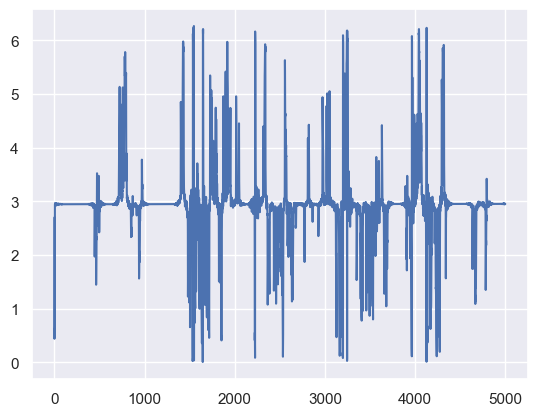

In [197]:
size = 5000
plt.plot(time_full[:size], train["y_mean"][:size])
plt.show()

# Feature Engineering

# Feature engineering to considder
1. Lags: carry over t number of lags into the feature. We expect only short time steps to be relevant for the curret step.
2. Rolling window aggregation: Calculate the average neuron activity and maybe also the variance for a set time period before the current time.
3. Time component: We may add the time as a variable. This is only relevant if there the time series is non-stationary. I think that this is unlikely given our data
4. Use unsupervised methods: This data was previously used to make a unsupervised model to categories neuron activity into descreate states. This was very effective at predicting regions of head movement and would probably be a very effective variable in this case. 
5. To reduce the dimensions of the data (number of neurons) we may use PCA on the neuron before we apply the above feature engineering. 

In [4]:
df_train = pd.read_csv("df_train.csv")
df_val = pd.read_csv("df_val.csv")

In [5]:
X_train = utils.getX(df_train)
y_train = df_train["headAngel"]

X_val = utils.getX(df_val)
y_val = df_val["headAngel"]

### Remove inactive

In [6]:
is_inactive = X_train.sum() == 0
X_train = X_train.loc[:,~is_inactive]
X_val = X_val.loc[:,~is_inactive]

### PCA

In [4]:
X_train, X_val = utils.pca_decomp(X_train, X_val, 20)

0.9335261770561484


In [6]:
rename = {}
for name in X_train.columns:
    rename[name] = "pca_" +str(name)
    

In [8]:
X_train = X_train.rename(columns = rename)
X_val = X_val.rename(columns = rename)

In [32]:
pca = PCA(n_components = 20)
 
X_train = pd.DataFrame(pca.fit_transform(X_train))
X_val = pd.DataFrame(pca.transform(X_val))
 
explained_variance = pca.explained_variance_ratio_

### Feature engineering

In [7]:
lags = 2

X_train_f, y_train_f = utils.feature_engineering(X_train, y_train, lags, mean_var=False)
X_train, y_train = utils.select_non_missing(X_train_f, y_train_f)

X_val_f, y_val_f = utils.feature_engineering(X_val, y_val, lags, mean_var = False)
X_val, y_val = utils.select_non_missing(X_val_f, y_val_f)

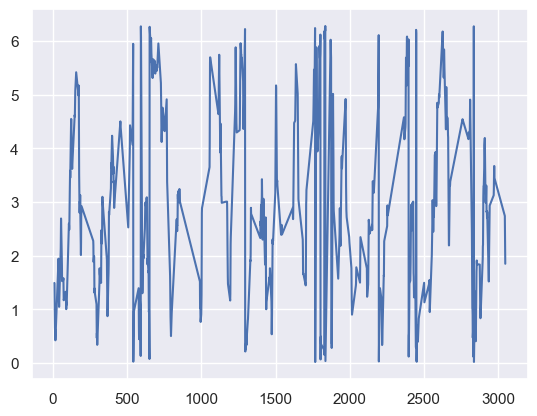

In [40]:
plt.plot(y_val)
plt.show()

In [8]:
y_train_sin = np.sin(y_train)
y_train_cos = np.cos(y_train)

y_val_sin = np.sin(y_val)
y_val_cos = np.cos(y_val)

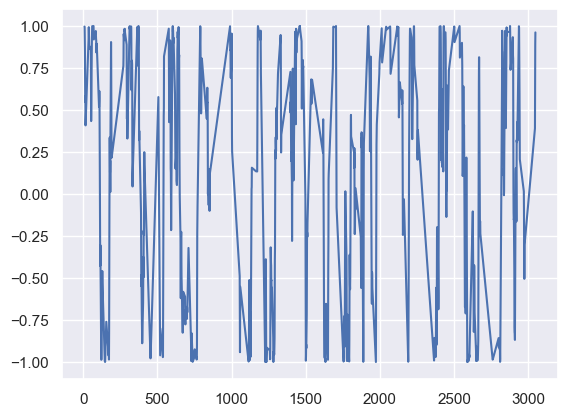

In [75]:
plt.plot(y_val_sin)
plt.show()

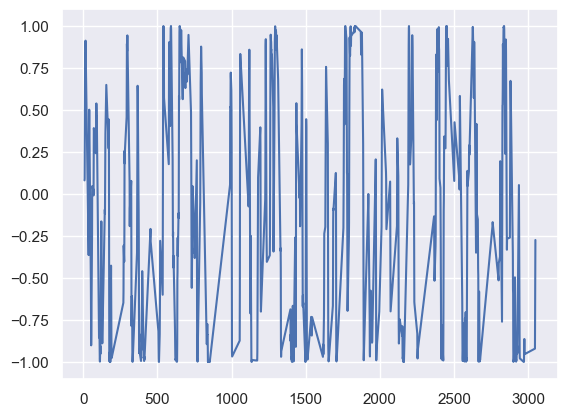

In [76]:
plt.plot(y_val_cos)
plt.show()

In [9]:
y_train_multi = utils.to_multi(y_train)
y_val_multi = utils.to_multi(y_val)

# Modeling

## XGBoost

In [61]:
model_xgb = xgb.XGBRegressor(n_estimators = 1000,
                             max_depth = 10,
                             learning_rate = 0.05)

model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [62]:
y_pred = model_xgb.predict(X_val)

In [63]:
mean_squared_error(y_pred, y_val)

0.6140186178025677

1. 4 lags: 0.6343097394701473
2. 10 lags: 0.8091682584918273
3. 20 PCA 10 lags: 1.475278806273055
4. 5 lags: 0.6517383383751592
5. 3 lags: 0.6113958403898271
6. 1 lag: 0.631272891521697
7. 2 lags: 0.6140186178025677

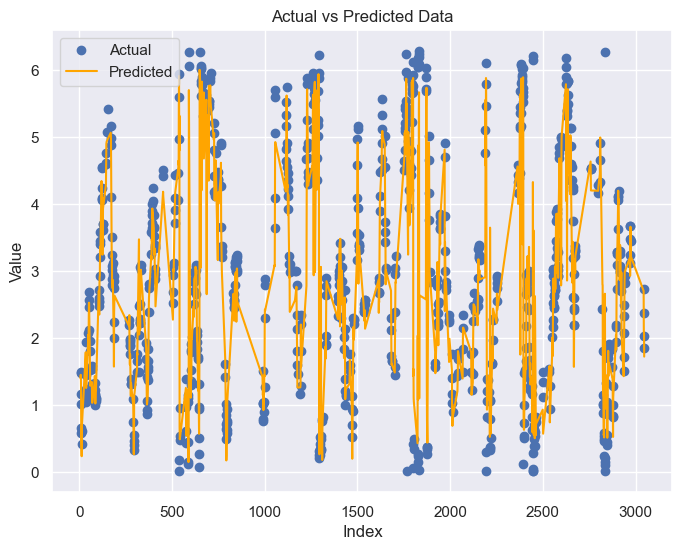

In [73]:
index_val = np.arange(len(y_val_f))[~np.isnan(y_val_f)]
# Plot
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.plot(index_val, y_val, "bo", label='Actual')  # Actual data points
plt.plot(index_val, y_pred, color="orange", label='Predicted')  # Predicted data line

# Customize plot
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data')
plt.legend()

# Display the plot
plt.show()


In general very high accuracy. However, the model is quite conservative and rearly predicts high or low radients, which does not really capture the cyclic nature of the target. We might solve this problem by representing the target with sine and cosine values and using multioutput regression.

### Multiregression

In [10]:
model_xgb_multi = MultiOutputRegressor(xgb.XGBRegressor(n_estimators = 1000,
                             max_depth = 10,
                             learning_rate = 0.05))

model_xgb_multi.fit(X_train, y_train_multi)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))

In [11]:
y_pred_multi = model_xgb_multi.predict(X_val)

In [15]:
y_pred_radiant = utils.to_radiant(y_pred_multi.transpose()[0], y_pred_multi.transpose()[1])

In [16]:
mean_squared_error(y_pred_radiant, y_val)

0.7105071434797217

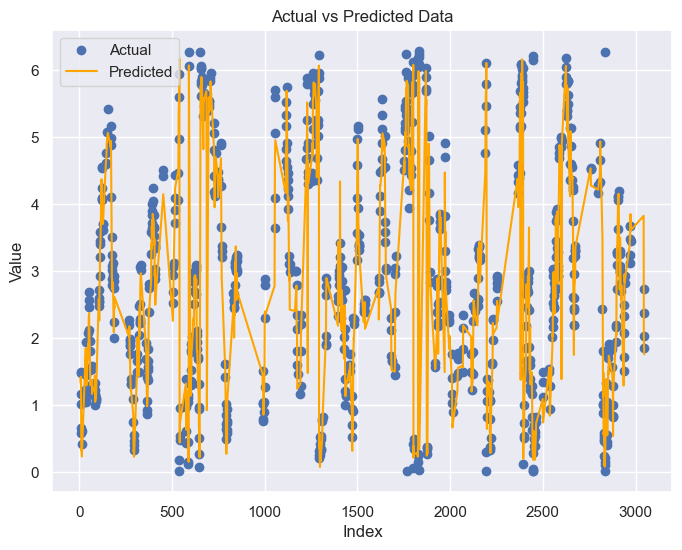

In [17]:
index_val = np.arange(len(y_val_f))[~np.isnan(y_val_f)]
# Plot
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.plot(index_val, y_val, "bo", label='Actual')  # Actual data points
plt.plot(index_val, y_pred_radiant, color="orange", label='Predicted')  # Predicted data line

# Customize plot
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data')
plt.legend()

# Display the plot
plt.show()


The model manages to reach higher peaks than before, but is in general less accurate.

Cosine

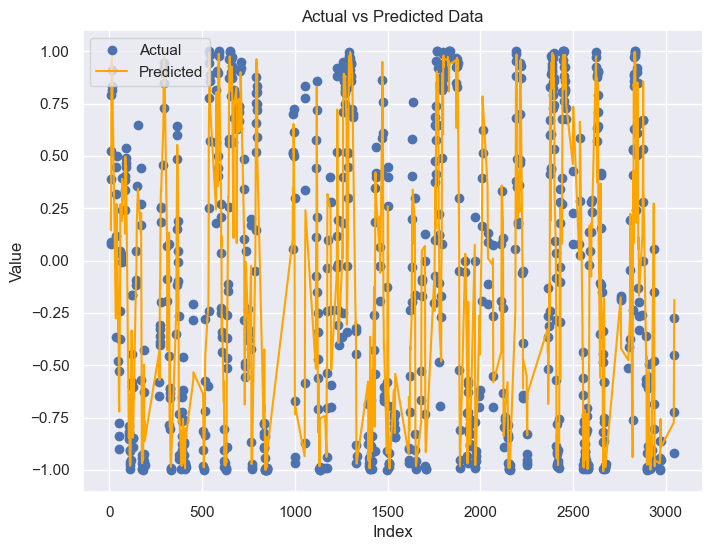

In [132]:
index_val = np.arange(len(y_val_f))[~np.isnan(y_val_f)]
# Plot
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.plot(index_val, np.cos(y_val), "bo", label='Actual')  # Actual data points
plt.plot(index_val, y_pred_multi.transpose()[0], color="orange", label='Predicted')  # Predicted data line

# Customize plot
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data')
plt.legend()

# Display the plot
plt.show()

Sine

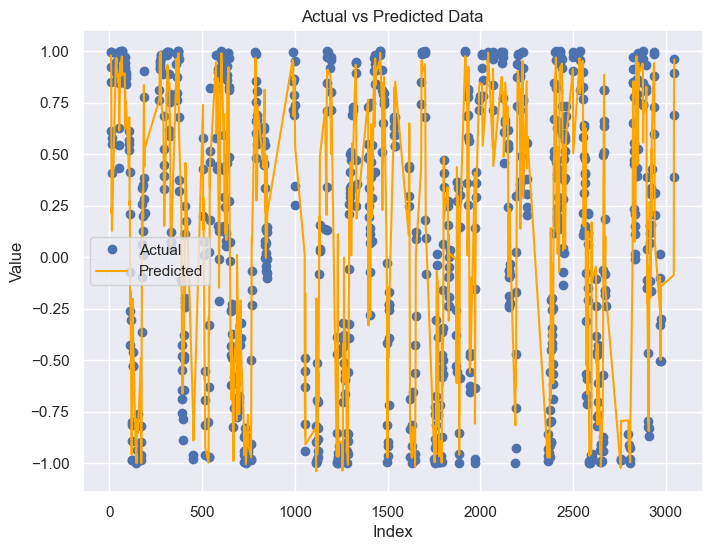

In [130]:
index_val = np.arange(len(y_val_f))[~np.isnan(y_val_f)]
# Plot
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.plot(index_val, np.sin(y_val), "bo", label='Actual')  # Actual data points
plt.plot(index_val, y_pred_multi.transpose()[1], color="orange", label='Predicted')  # Predicted data line

# Customize plot
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data')
plt.legend()

# Display the plot
plt.show()